In [1]:
import os
import pickle
import ledapy
import tqdm
import datetime
import neurokit2 as nk
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
sample_data_path = './processed/c1s001/0.pkl'
with open(sample_data_path, 'rb') as f:
    cgm_data = pickle.load(f)

fs = 250
window_size = 3 * fs 

ecg_data = cgm_data['zephyr']['ECG']
summary_data = cgm_data['zephyr']['Summary']

ecg_data['Time'] = pd.to_datetime(ecg_data['Time'])
summary_data = pd.DataFrame(summary_data)

In [ ]:
ecg_clean = nk.ecg_clean(ecg_data['EcgWaveform'], sampling_rate=fs)
_, rpeaks = nk.ecg_peaks(ecg_clean, sampling_rate=fs, correct_artifacts=True)
r_peaks = np.unique(rpeaks['ECG_R_Peaks'])

extracted_ecg = []
for peak in tqdm.tqdm(r_peaks):
    start_idx = peak - window_size//2
    end_idx = min(start_idx + window_size, ecg_clean.shape[0] - 1)

    start_t = ecg_data['Time'][start_idx]
    end_t = ecg_data['Time'][end_idx]
    beat_ecg = ecg_clean[start_idx:end_idx + 1]

    if beat_ecg.shape[0] == 0:
        continue
    
    summary_window = (summary_data['Time'] >= start_t) & (summary_data['Time'] < end_t)
    avg_HRConfidence = summary_data["HRConfidence"][summary_window].mean()
    avg_ECGNoise = summary_data["ECGNoise"][summary_window].mean()

    extracted_ecg.append({
        'ecg': beat_ecg,
        'start_t': start_t,
        'end_t': end_t,
        'glucose': cgm_data['glucose'],
        'CGM_idx': cgm_data['Index'],
        'Timestamp': cgm_data['Timestamp'],
        'HRConfidence': avg_HRConfidence,
        'ECGNoise': avg_ECGNoise
    })

extracted_ecg = pd.DataFrame(extracted_ecg)


100%|██████████| 324/324 [00:00<00:00, 2931.13it/s]


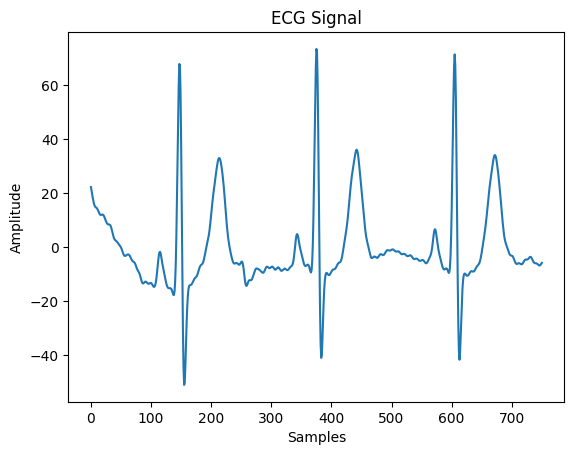

In [23]:
plt.plot(extracted_ecg['ecg'].iloc[0])
plt.title('ECG Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()